# Goal

I want to look for relationship between phgy parameters and data quality (defined by correlation with spatial prior), and ultimately determine the optimal physiological state (combo of phgy param) at which the mouse should be maintained during a scan.

Overall process: Individual level spatial priors were determined using dual-regression (this approach was chosen over dual-ICA to avoid the complication of choosing the number of components to be fitted). The fitted individual level spatial prior was correlated with the original group-level spatial prior to evaluate how well it could be recovered in a given scan. This process was performed in a time window (2 min) to obtain an estimate of 'data quality' over time. Thus, by having 'data quality' and physiology over time, we have the ability to determine the optimal physiological state for each individual subject.

Data: 6 control mice (C3HeB/FeJ), 10 min long fMRI scan with simultaneous physiological recordings. Shimming was performed. Standard anesthesia protocol (demedetomidine bolus injection, 0.5% iso delivered in 80/20 oxygen/air mixture, followed by continuous dexmedetomidine infusion).

# Functions

In [1]:
from sklearn.utils import check_random_state
import numpy as np
import nibabel as nb
import glob
import rabies.preprocess_pkg.utils
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import matplotlib.backends.backend_pdf

# import functions for dual ICA from rabies
from rabies.analysis_pkg.data_diagnosis import resample_IC_file
from rabies.analysis_pkg.analysis_functions import closed_form
from rabies.analysis_pkg.prior_modeling import _logcosh

C:\Users\muros\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
#redefine deflation_fit here to include a seed (the original RABIES func does not use a seed)
def deflation_fit(X, q=1, c_init=None, C_convergence='OLS', C_prior=None, W_prior=None, W_ortho=False, tol=1e-6, 
                  max_iter=200, verbose=1):
    # q defines the number of new sources to fit
    if c_init is None:
        random_state = check_random_state(0)
        c_init = random_state.normal(
            size=(X.shape[1], q))

    # the C_prior and W_prior correspond to spatial and temporal priors respectively which will impose an orthogonality contraint
    # on the fitted sources in their respective dimension
    if C_prior is None:
        C_prior = np.zeros([X.shape[1], 0])
    C_prior /= np.sqrt((C_prior ** 2).sum(axis=0))

    if W_prior is None:
        W_prior = np.zeros([X.shape[0], 0])
    W_prior /= np.sqrt((W_prior ** 2).sum(axis=0))

    # initialize an empty C
    C = np.zeros([X.shape[1], 0])
    for j in range(q):
        C_prev = np.concatenate((C, C_prior), axis=1)
        c = c_init[:, j].reshape(-1, 1)
        c /= np.sqrt((c ** 2).sum(axis=0))

        # regress out the orthogonal dimensions already fitted
        X_ = X-np.matmul(np.matmul(X, C_prev), C_prev.T)

        for i in range(max_iter):
            c_prev = c

            w = np.matmul(X_, c)
            if W_ortho and (W_prior.shape[1]>0):
                # impose complete temporal orthogonality, more similar to CR before but not quite the same
                w -= np.matmul(W_prior, closed_form(W_prior, w))
            W = np.concatenate((w,W_prior),axis=1) # include the W priors in the convergence step

            if C_convergence == 'OLS':
                c = closed_form(W, X_).T[:,0].reshape(-1, 1) # take back only c
            elif C_convergence == 'ICA':
                gwtx, g_wtx = _logcosh(W[:,0].reshape(1,-1), {})
                c = ((X_.T * gwtx).mean(axis=1) - g_wtx.mean() * c.T).T
            else:
                raise

            # impose spatial orthogonality
            c -= np.matmul(np.matmul(c.T, C_prev), C_prev.T).T
            c /= np.sqrt((c ** 2).sum(axis=0))

            ##### evaluate convergence
            lim = np.abs(np.abs((c * c_prev).sum(axis=0)) - 1).mean()
            if verbose > 2:
                print('lim:'+str(lim))
            if lim < tol:
                if verbose > 1:
                    print(str(i)+' iterations to converge.')
                break
            if i == max_iter-1:
                if verbose > 0:
                    print(
                        'Convergence failed. Consider increasing max_iter or decreasing tol.')
        C = np.concatenate((C, c), axis=1)
    return C

In [3]:
#FROM RABIES
def dual_regression(all_IC_vectors, timeseries):
    ### compute dual regression
    ### Here, we adopt an approach where the algorithm should explain the data
    ### as a linear combination of spatial maps. The data itself, is only temporally
    ### detrended, and not spatially centered, which could cause inconsistencies during
    ### linear regression according to https://mandymejia.com/2018/03/29/the-role-of-centering-in-dual-regression/#:~:text=Dual%20regression%20requires%20centering%20across%20time%20and%20space&text=time%20points.,each%20time%20course%20at%20zero
    ### The fMRI timeseries aren't assumed theoretically to be spatially centered, and
    ### this measure would be removing global signal variations which we are interested in.
    ### Thus we prefer to avoid this step here, despite modelling limitations.
    X = all_IC_vectors.T
    Y = timeseries.T
    # for one given volume, it's values can be expressed through a linear combination of the components
    W = closed_form(X, Y, intercept=False).T
    # normalize the component timecourses to unit variance
    W /= W.std(axis=0)
    # for a given voxel timeseries, it's signal can be explained a linear combination of the component timecourses
    C = closed_form(W, Y.T, intercept=False)
    DR = {'C':C, 'W':W}
    return DR

In [4]:
#FROM RABIES
#the fitting function must be redefined here since I changed deflation_fit function
def dual_ICA_fit(timeseries, num_comp, all_IC_vectors, prior_bold_idx):
    prior_fit_out={'C':[],'W':[]}
    convergence_function = 'ICA'
    X=timeseries

    prior_networks = all_IC_vectors[prior_bold_idx,:].T

    C_prior=prior_networks
    C_conf = deflation_fit(X, q=num_comp, c_init=None, C_convergence=convergence_function,
                      C_prior=C_prior, W_prior=None, W_ortho=True, tol=1e-6, max_iter=200, verbose=1)
    for network in range(prior_networks.shape[1]):
        prior=prior_networks[:,network].reshape(-1,1)
        C_prior=np.concatenate((prior_networks[:,:network],prior_networks[:,network+1:],C_conf),axis=1)

        C_fit = deflation_fit(X, q=1, c_init=prior, C_convergence=convergence_function,
                              C_prior=C_prior, W_prior=None, W_ortho=True, tol=1e-6, max_iter=200, verbose=1)

        # make sure the sign of weights is the same as the prior
        corr = np.corrcoef(C_fit.flatten(), prior.flatten())[0, 1]
        if corr < 0:
            C_fit = C_fit*-1

        # the finalized C
        C = np.concatenate((C_fit, C_prior), axis=1)

        # L-2 norm normalization of the components
        C /= np.sqrt((C ** 2).sum(axis=0))
        W = closed_form(C,X.T, intercept=False).T
        # the components will contain the weighting/STD/singular value, and the timecourses are normalized
        C=C*W.std(axis=0)
        # normalize the component timecourses to unit variance
        W /= W.std(axis=0)

        prior_fit_out['C'].append(C[:,0])
        prior_fit_out['W'].append(W[:,0])
    return prior_fit_out

In [5]:
#define function for plotting
def recover_3D(mask_file, vector_map):
    brain_mask = np.asarray(nb.load(mask_file).dataobj)
    volume_indices = brain_mask.astype(bool)
    volume = np.zeros(brain_mask.shape)
    volume[volume_indices] = vector_map
    volume_img = nb.Nifti1Image(volume, nb.load(mask_file).affine, nb.load(mask_file).header)
    return volume_img

In [6]:
#define function that extracts a vector from the raw image file
def preprocess_epi(epi_path_string, mask_path_string):
    
    #load the image as an array
    epi = np.asarray(nb.load(epi_path_string).dataobj)
    mask= np.asarray(nb.load(mask_path_string).dataobj)
    
    #apply mask to epi (this also flattens it)
    volume_indices = mask.astype(bool)
    epi_masked = epi[volume_indices]    
    
    
    return epi, mask, epi_masked

In [7]:
def dual_regr_time_window_exact(epi_masked_flat, desired_component_to_fit, mask, background_im,
                         num_timepoints, window_width, window_overlap):
    """This version of the function is useful if you know exactly how many components you want to use in your fit,
    and which EPI version you want (eg with CR vs without CR)"""
    
    #reshape the group-level ICA component that you wish to fit from 1D into 2D (with a dimension of one)
    desired_component_to_fit_reshaped = np.reshape(desired_component_to_fit, (1,-1))
    
    #create an empty dataframe to add info from each time window
    dfObj = pd.DataFrame(columns=['Start Time', 'End Time', 'Correlation', 'p-value'])
    
    #extract a time window
    window_start = 0 
    
    while window_start + window_width <= num_timepoints:
        
        window_end = window_start + window_width
        
        #extract only the part of the EPI inside the time window (it must be transposed to put time dimension first)
        epi_segment = np.transpose(epi_masked_flat)[window_start:window_end, :]
    
        #perform the dual-ICA fitting
        fit_out = dual_regression(desired_component_to_fit_reshaped, epi_segment)
        
        #plot the fit in each time window
        fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
        plot_stat_map(recover_3D(mask, fit_out['C'][0]),bg_img=background_im, 
                      axes = ax, cut_coords=(0,1,2,3,4,5), display_mode='y', colorbar=True)
        ax.set_title('Window start:' + str(window_start))

        #calculate the correlation of the subject-specific fitted component with the original group-level component
        fit_to_original_corr = stats.pearsonr(fit_out['C'][0], desired_component_to_fit)
        
        
        #add information from this window to the dataframe
        dfObj = dfObj.append({'Start Time': window_start, 'End Time': window_end, 'Correlation': fit_to_original_corr[0],
                              'p-value': fit_to_original_corr[1]}, ignore_index=True)
        
        #set the start time of the next window
        window_start = window_start + window_overlap
    
    return dfObj

In [8]:
def dual_reg_time_window_experimental(epi_masked_flat_CR, epi_masked_flat_no_CR, desired_component_to_fit, mask, background_im, 
                                      num_timepoints, window_width, window_overlap):
    """This version of the function allows you to compare EPI with CR vs without"""
    
    #reshape the group-level ICA component that you wish to fit from 1D into 2D (with a dimension of one)
    desired_component_to_fit_reshaped = np.reshape(desired_component_to_fit, (1,-1))
    
    #create an empty dataframe to add info from each time window
    dfObj = pd.DataFrame(columns=['Start Time', 'End Time'])
    dfObj_avg = pd.DataFrame(columns=['Start Time', 'End Time'])
    
    #extract a time window
    window_start = 0 

    #create arrays to store the correlation values for for all windows
    fit_corr_array_CR = np.array([])
    fit_corr_array_no_CR = np.array([])
    fit_cov_array_CR = np.array([])
    fit_cov_array_no_CR = np.array([])
    start_array = np.array([])
    end_array = np.array([])

    while window_start + window_width <= num_timepoints:

        window_end = window_start + window_width

        #extract only the part of the EPI inside the time window (it must be transposed to put time dimension first)
        epi_segment_CR = np.transpose(epi_masked_flat_CR)[window_start:window_end, :]
        epi_segment_no_CR = np.transpose(epi_masked_flat_no_CR)[window_start:window_end, :]

        #perform the dual-ICA fitting
        try:
            fit_out_CR = dual_regression(desired_component_to_fit_reshaped, epi_segment_CR)
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print('window starting at ' + str(window_start) + ' with CR, had singular matrix')
            else:
                raise
            
        try:
            fit_out_no_CR = dual_regression(desired_component_to_fit_reshaped, epi_segment_no_CR)
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print('window starting at ' + str(window_start) + ' with no CR, had singular matrix')
            else:
                raise

        #plot the fit in each time window (only for, with CR)
        fig1,ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
        plot_stat_map(recover_3D(mask, fit_out_CR['C'][0]),bg_img=background_im, axes = ax1, 
                     cut_coords=(0,1,2,3,4,5), display_mode='y', colorbar=True, vmax =1, 
                      title = ' CR, Window start:' + str(window_start))

        #calculate the correlation of the subject-specific fitted component with the original group-level component
        fit_to_original_corr_CR = stats.pearsonr(fit_out_CR['C'][0], desired_component_to_fit)
        fit_to_original_corr_no_CR = stats.pearsonr(fit_out_no_CR['C'][0], desired_component_to_fit)
        
        #calculate the covariance as well
        fit_to_original_cov_CR = np.cov(fit_out_CR['C'][0], desired_component_to_fit)
        fit_to_original_cov_no_CR = np.cov(fit_out_no_CR['C'][0], desired_component_to_fit)

        #add information from this window to the array (append new row)
        fit_corr_array_CR = np.append(fit_corr_array_CR, fit_to_original_corr_CR[0])
        fit_corr_array_no_CR = np.append(fit_corr_array_no_CR, fit_to_original_corr_no_CR[0])
        fit_cov_array_CR = np.append(fit_cov_array_CR, fit_to_original_cov_CR[1,0])
        fit_cov_array_no_CR = np.append(fit_cov_array_no_CR, fit_to_original_cov_no_CR[1,0])
        start_array = np.append(start_array, window_start)
        end_array = np.append(end_array, window_end)

        #set the start time of the next window
        window_start = window_start + window_overlap

    #now add the information from this condition (num of components) as a column
    len(fit_corr_array_no_CR)
    len(fit_cov_array_no_CR)
    dfObj['Start Time'] = start_array
    dfObj['End Time'] = end_array
    dfObj['Correlation, CR'] = fit_corr_array_CR
    dfObj['Correlation, no CR'] = fit_corr_array_no_CR
    dfObj['Covariance, CR'] = fit_cov_array_CR
    dfObj['Covariance, no CR'] = fit_cov_array_no_CR

    #now average the correlations from two overlapping time windows to get values for every 30 s
    dfObj_avg['Start Time'] = np.append(start_array, window_start)
    dfObj_avg['End Time'] = np.append(end_array-window_overlap, num_timepoints)
    dfObj_avg['Correlation, CR'] = (np.pad(fit_corr_array_CR,(0,1), 'edge') + np.pad(fit_corr_array_CR,(1,0), 'edge'))/2
    dfObj_avg['Correlation, no CR'] = (np.pad(fit_corr_array_no_CR,(0,1), 'edge') + np.pad(fit_corr_array_no_CR,(1,0), 'edge'))/2
    dfObj_avg['Covariance, CR'] = (np.pad(fit_cov_array_CR,(0,1), 'edge') + np.pad(fit_cov_array_CR,(1,0), 'edge'))/2
    dfObj_avg['Covariance, no CR'] = (np.pad(fit_cov_array_no_CR,(0,1), 'edge') + np.pad(fit_cov_array_no_CR,(1,0), 'edge'))/2

    #get a value for each second by repeating the value in the window for the window length
    dfObj_avg_long = pd.DataFrame(dfObj_avg.values.repeat(window_width - window_overlap, axis=0), columns=dfObj_avg.columns)
    return dfObj, dfObj_avg_long

In [9]:
def dual_ICA_full_std_timewindow(epi_masked_flat_CR, epi_masked_flat_no_CR,
                                      desired_component_to_fit, mask, background_im, 
                                      num_comp_to_fit_CR, num_comp_to_fit_no_CR, num_timepoints, window_width, window_overlap):
    """This function performs dual-ICA on full timecourse, then breaks it up into windows and finds the std of the component
    across time within each window"""
    
    #reshape the group-level ICA component that you wish to fit from 1D into 2D (with a dimension of one)
    desired_component_to_fit_reshaped = np.reshape(desired_component_to_fit, (1,-1))
    
    #perform dual-ICA on full timecourse
    prior_fit_out_CR = dual_ICA_fit(np.transpose(epi_masked_flat_CR), num_comp_to_fit_CR, 
                                    desired_component_to_fit_reshaped, [0])
    prior_fit_out_noCR = dual_ICA_fit(np.transpose(epi_masked_flat_no_CR), num_comp_to_fit_no_CR, 
                                      desired_component_to_fit_reshaped, [0])
    
    #create an empty dataframe to add info from each time window
    df_std = pd.DataFrame(columns=['Start Time', 'End Time'])
    df_std_avg = pd.DataFrame(columns=['Start Time', 'End Time'])
    
    #extract a time window
    window_start = 0 

    #create arrays to store the correlation values for for all windows
    std_CR = np.array([])
    std_no_CR = np.array([])
    start_array = np.array([])
    end_array = np.array([])

    while window_start + window_width <= num_timepoints:

        window_end = window_start + window_width

        #extract only the part of the fitted_prior timecourse inside the time window 
        prior_fit_out_segment_CR = prior_fit_out_CR['W'][0][window_start:window_end]
        prior_fit_out_segment_noCR = prior_fit_out_noCR['W'][0][window_start:window_end]


        #find the std within that time window
        prior_fit_out_segment_std_CR = np.std(prior_fit_out_segment_CR)
        prior_fit_out_segment_std_noCR = np.std(prior_fit_out_segment_noCR)
        
        #add information from this window to the array (append new row)
        std_CR = np.append(std_CR, prior_fit_out_segment_std_CR)
        std_no_CR = np.append(std_no_CR, prior_fit_out_segment_std_noCR)
        start_array = np.append(start_array, window_start)
        end_array = np.append(end_array, window_end)

        #set the start time of the next window
        window_start = window_start + window_overlap

    #now add the information from this condition (num of components) as a column
    df_std['Start Time'] = start_array
    df_std['End Time'] = end_array
    df_std['std, CR, '+ str(num_comp_to_fit_CR) + ' components'] = std_CR
    df_std['std, no CR, '+ str(num_comp_to_fit_no_CR) + ' components'] = std_no_CR

    #now average the correlations from two overlapping time windows to get values for every 30 s
    df_std_avg['Start Time'] = np.append(start_array, window_start)
    df_std_avg['End Time'] = np.append(end_array-window_overlap, num_timepoints)
    df_std_avg['std, CR, '+ str(num_comp_to_fit_CR) + ' components'] = (np.pad(std_CR,(0,1), 'edge') + np.pad(std_CR,(1,0), 'edge'))/2
    df_std_avg['std, no CR, '+ str(num_comp_to_fit_no_CR) + ' components'] = (np.pad(std_no_CR,(0,1), 'edge') + np.pad(std_no_CR,(1,0), 'edge'))/2

    #get a value for each second by repeating the value in the window for the window length
    df_std_avg_long = pd.DataFrame(df_std_avg.values.repeat(window_width - window_overlap, axis=0), columns=df_std_avg.columns)
    return df_std, df_std_avg_long

# Load data

The masks are from the niagara folder /scratch/m/mchakrav/uromil/rabies_runs/dual-ICA_testing/rabies_outputs/bold_datasink/commonspace_mask/. They are actually all in the same space.

The commonspace template is from the niagara folder /scratch/m/mchakrav/uromil/rabies_runs/dual-ICA_testing/rabies_outputs/main_wf/resample_template/

this EPI data is from the niagara folder /scratch/m/mchakrav/uromil/rabies_runs/dual-ICA_testing/rabies_outputs/default_CR_wf_datasink/cleaned_timseries

In [10]:
commonspace_template_file = "../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR/resampled_template.nii.gz"
spatial_prior_file = "../../1_reference_data/PCA_spatial_prior_gabe_resampled.nii.gz"
mask_files = sorted(glob.glob("../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR/*mask*"))
epi_files = sorted(glob.glob("../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_detrend_only/*EPI*cleaned.nii.gz*"))
epi_files_CR = sorted(glob.glob("../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR/*EPI*cleaned.nii.gz*"))

In [11]:
epi_files_CR

['../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-001_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned.nii.gz',
 '../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-002_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned.nii.gz',
 '../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-003_ses-1_rest_acq-EPI_run-2_bold_RAS_combined_cleaned.nii.gz',
 '../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-004_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned.nii.gz',
 '../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-005_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned.nii.gz',
 '../../4_derivatives/rabies_outputs_select/august_2021_dual-ICA_testing_CR\\sub-006_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned.nii.gz']

# Preprocess 

In [12]:
spatial_prior, mask, spatial_prior_masked_flat = preprocess_epi(spatial_prior_file, mask_files[0])

In [13]:
epi_001_CR, mask, epi_001_masked_flat_CR = preprocess_epi(epi_files_CR[0], mask_files[0])
epi_002_CR, mask, epi_002_masked_flat_CR = preprocess_epi(epi_files_CR[1], mask_files[0])
epi_003_CR, mask, epi_003_masked_flat_CR = preprocess_epi(epi_files_CR[2], mask_files[0])
epi_004_CR, mask, epi_004_masked_flat_CR = preprocess_epi(epi_files_CR[3], mask_files[0])
epi_005_CR, mask, epi_005_masked_flat_CR = preprocess_epi(epi_files_CR[4], mask_files[0])
epi_006_CR, mask, epi_006_masked_flat_CR = preprocess_epi(epi_files_CR[5], mask_files[0])

In [14]:
epi_001, mask, epi_001_masked_flat = preprocess_epi(epi_files[0], mask_files[0])
epi_002, mask, epi_002_masked_flat = preprocess_epi(epi_files[1], mask_files[0])
epi_003, mask, epi_003_masked_flat = preprocess_epi(epi_files[2], mask_files[0])
epi_004, mask, epi_004_masked_flat = preprocess_epi(epi_files[3], mask_files[0])
epi_005, mask, epi_005_masked_flat = preprocess_epi(epi_files[4], mask_files[0])
epi_006, mask, epi_006_masked_flat = preprocess_epi(epi_files[5], mask_files[0])

# Dual-Regression 

 The colours that are plotted in the stat map are the values of the regression coefficient (stronger means that a greater part of the data corresponds to this effect (ie the fitted prior)).

## Execute within 2 min time window (1m overlap)

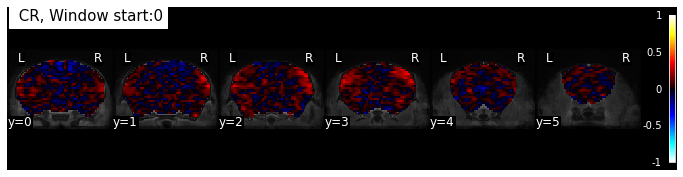

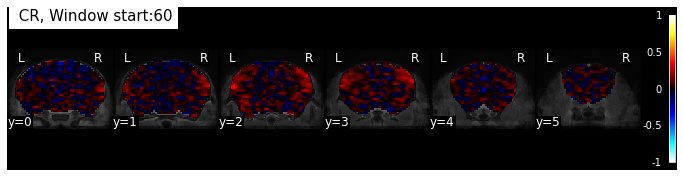

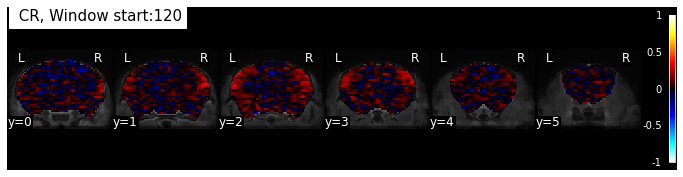

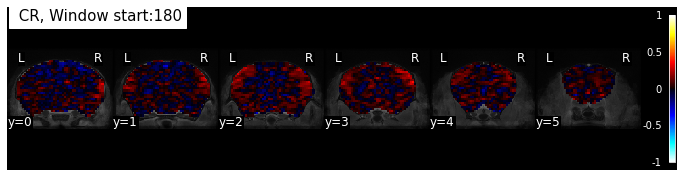

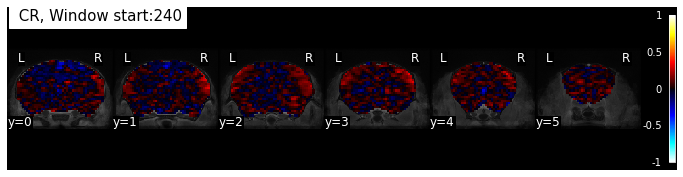

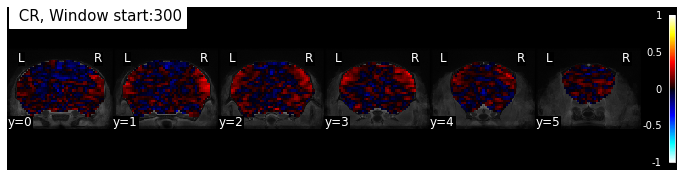

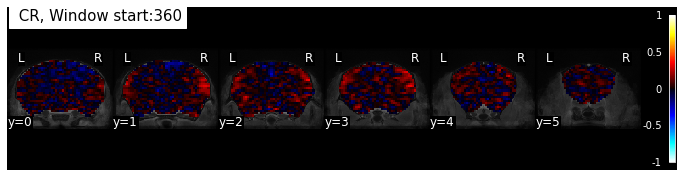

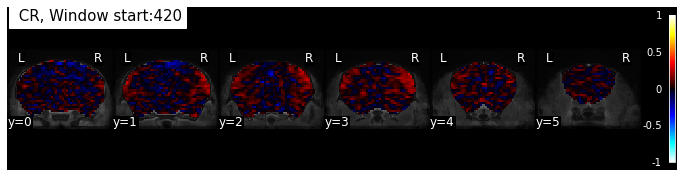

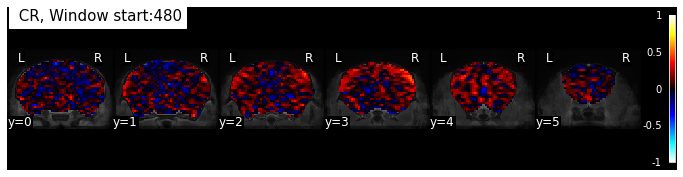

In [21]:
df_001_prior_corr_2min, df_001_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_001_masked_flat_CR, 
                                                                                       epi_001_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0], 
                                                                             commonspace_template_file, 600, 120, 
                                                                             60)

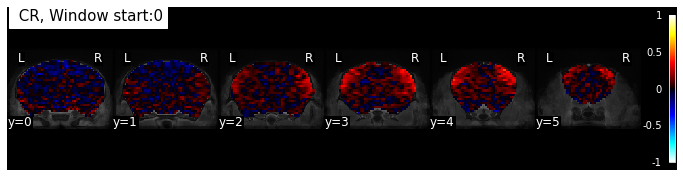

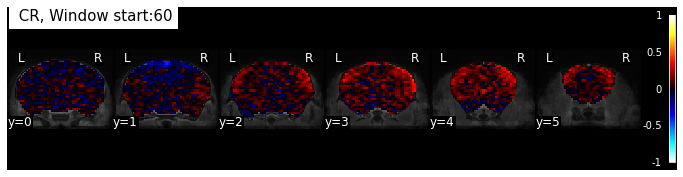

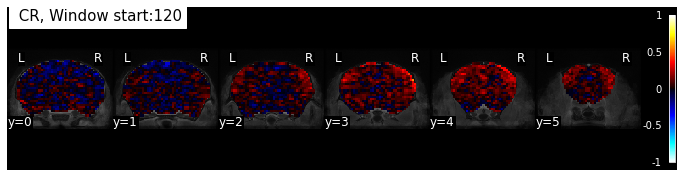

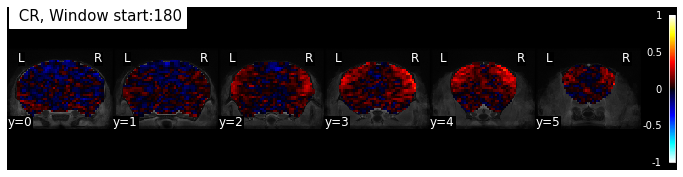

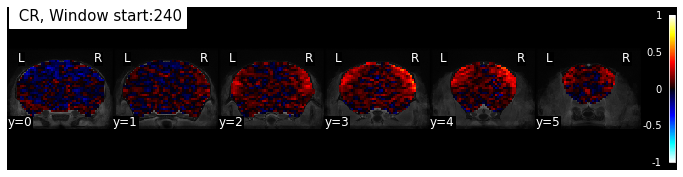

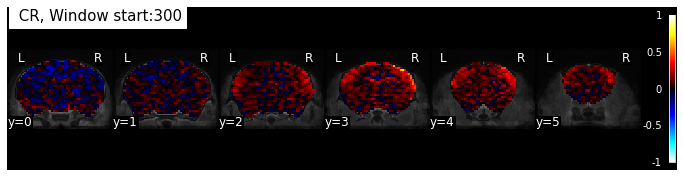

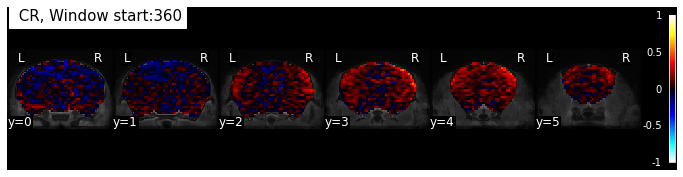

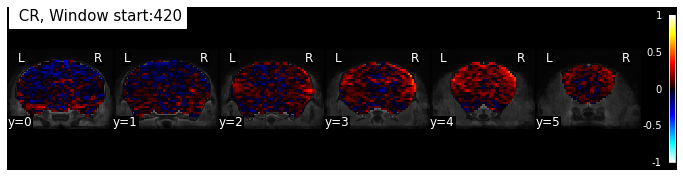

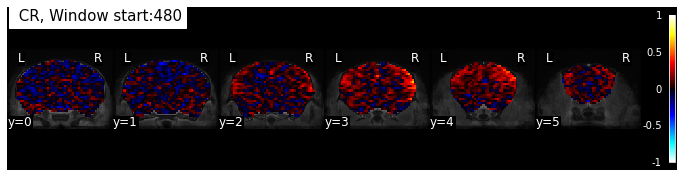

In [22]:
df_002_prior_corr_2min, df_002_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_002_masked_flat_CR, 
                                                                                       epi_002_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0],
                                                                             commonspace_template_file, 600, 120, 
                                                                             60)

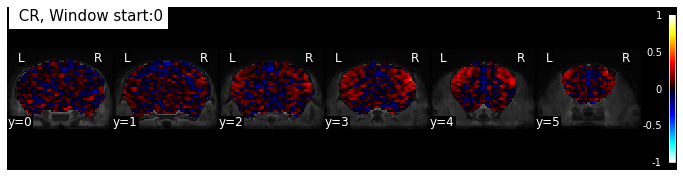

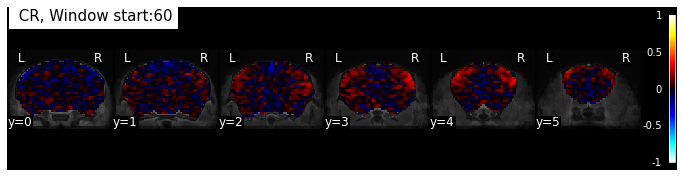

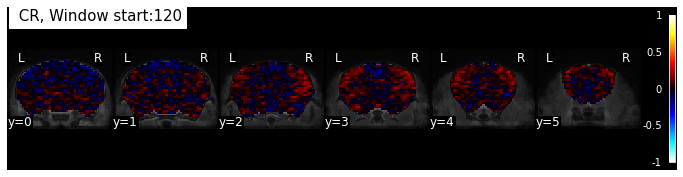

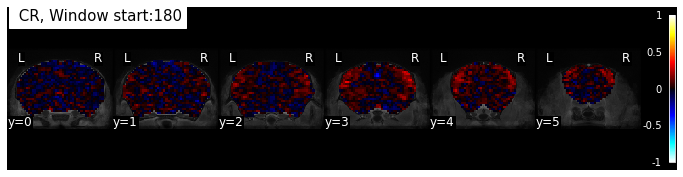

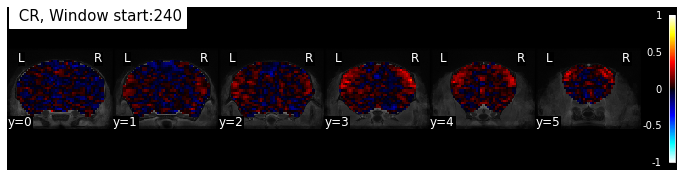

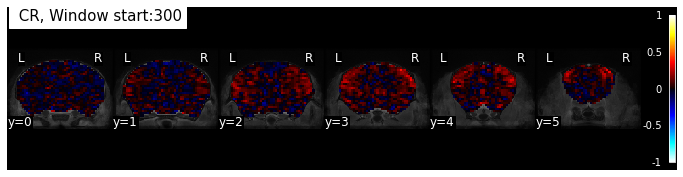

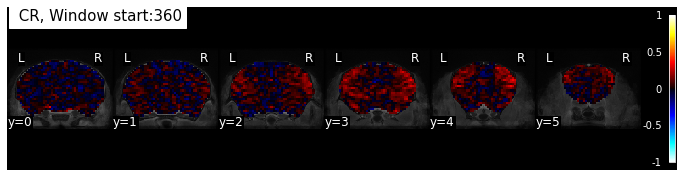

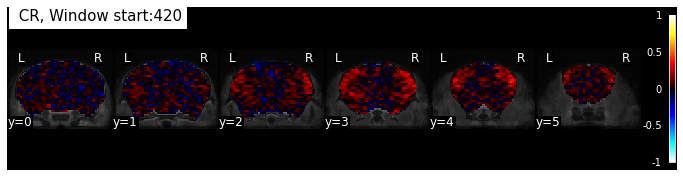

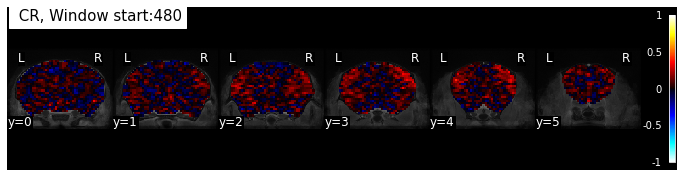

In [23]:
df_003_prior_corr_2min, df_003_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_003_masked_flat_CR, 
                                                                                       epi_003_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0], 
                                                                             commonspace_template_file, 600, 
                                                                             120, 60)

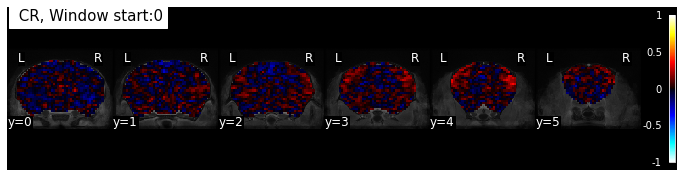

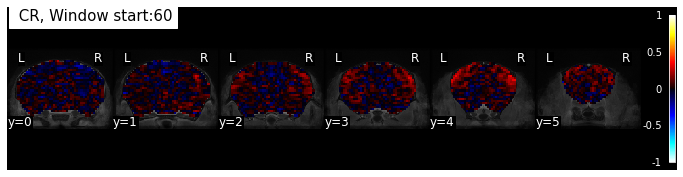

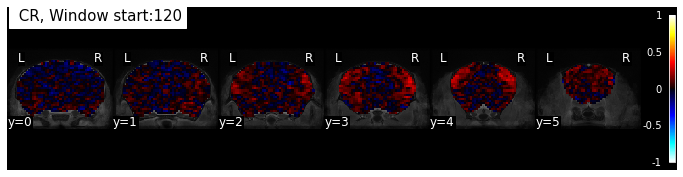

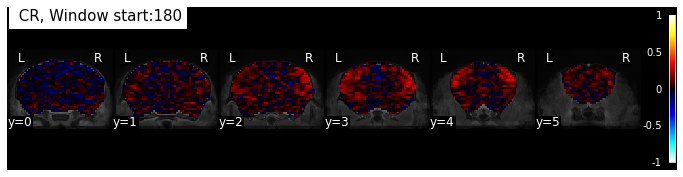

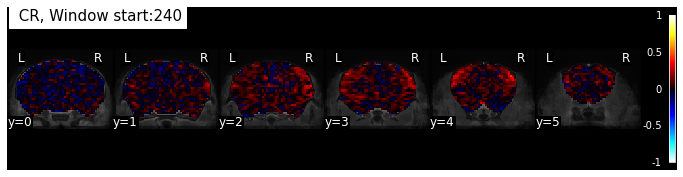

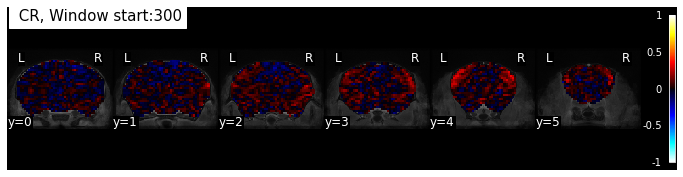

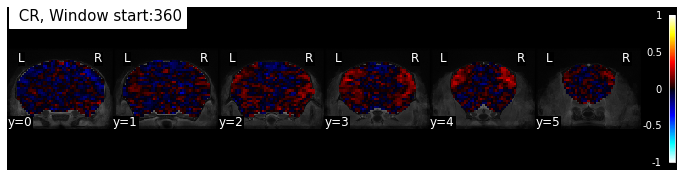

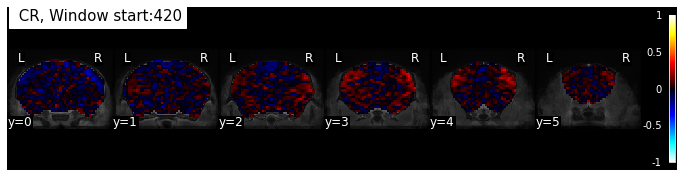

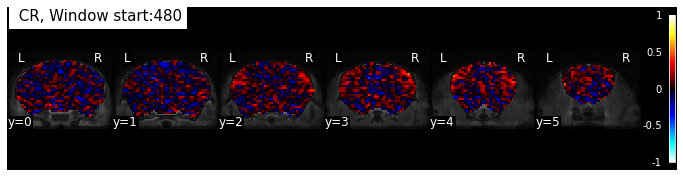

In [24]:
df_004_prior_corr_2min, df_004_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_004_masked_flat_CR, 
                                                                                       epi_004_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0], 
                                                                             commonspace_template_file, 600, 
                                                                             120, 60)

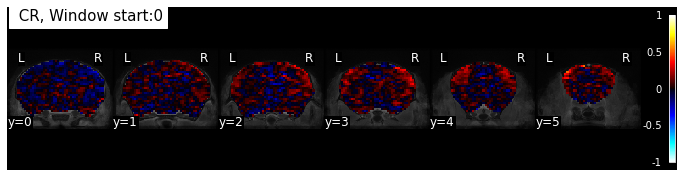

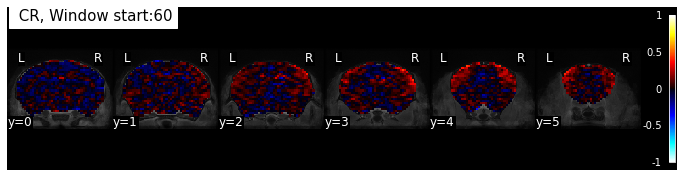

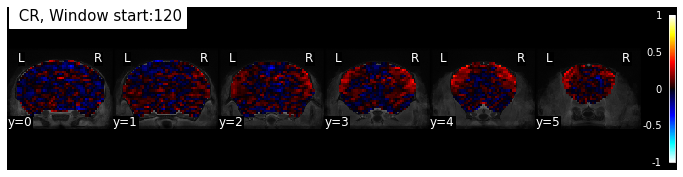

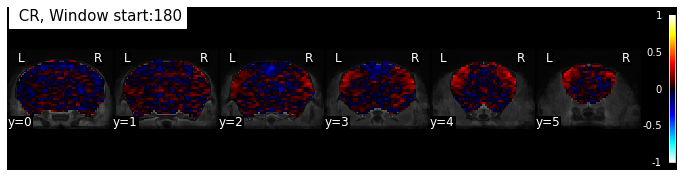

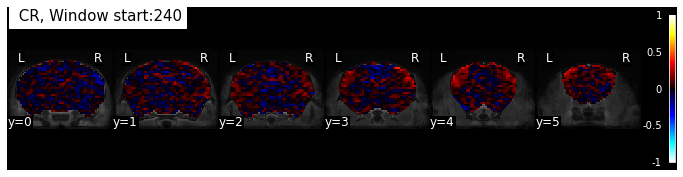

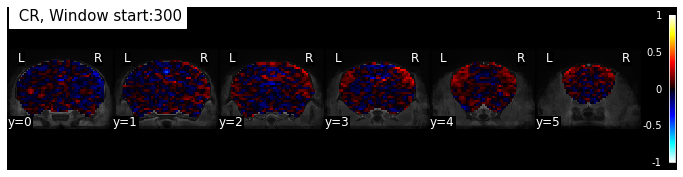

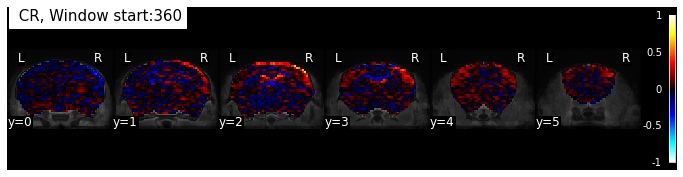

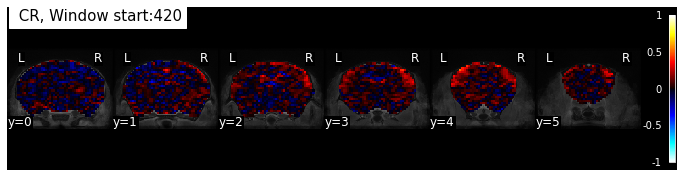

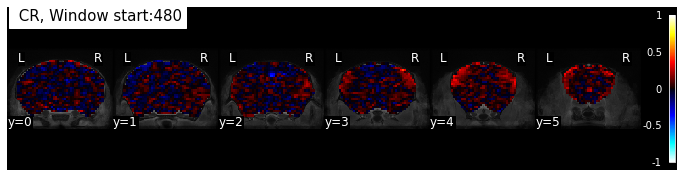

In [25]:
df_005_prior_corr_2min, df_005_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_005_masked_flat_CR, 
                                                                                       epi_005_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0], 
                                                                             commonspace_template_file, 600, 
                                                                             120, 60)

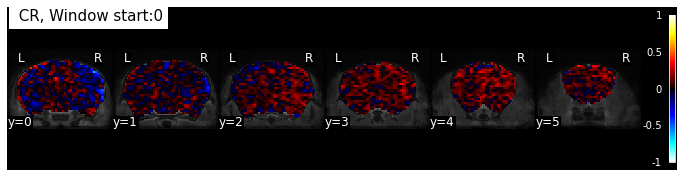

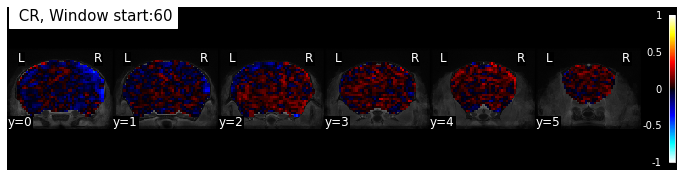

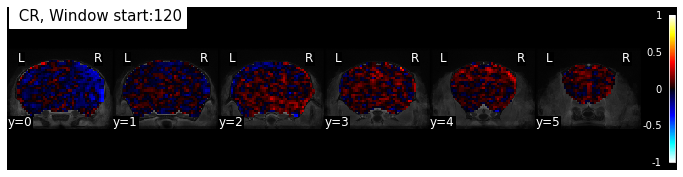

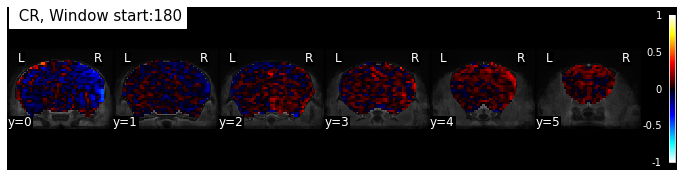

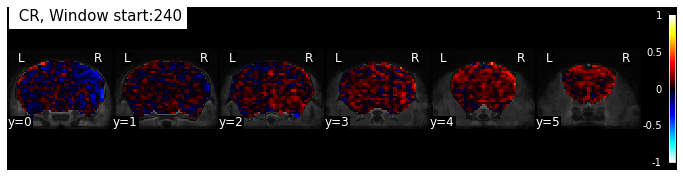

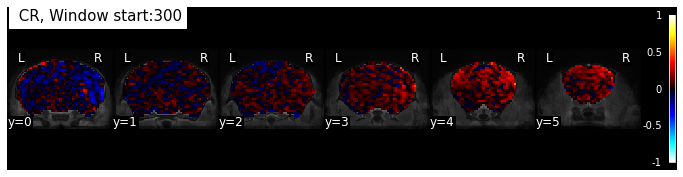

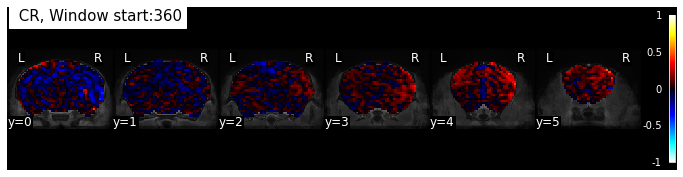

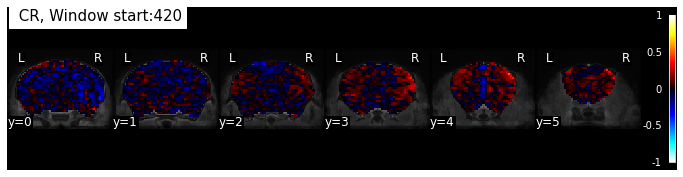

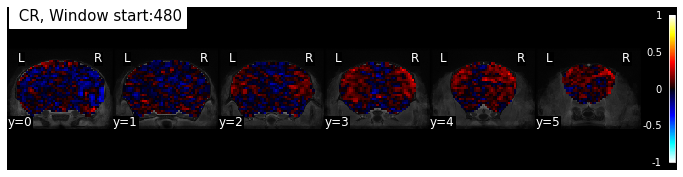

In [26]:
df_006_prior_corr_2min, df_006_prior_corr_avg_2min = dual_reg_time_window_experimental(epi_006_masked_flat_CR, 
                                                                                       epi_006_masked_flat, 
                                                                             spatial_prior_masked_flat, mask_files[0], 
                                                                             commonspace_template_file, 600, 
                                                                             120, 60)

## Extract stddev of fitted prior timecourse

Perform the fitting on the full timecourse of 10 min, using the number of components that has previously been determined to be optimal for that subject (see dual-ICA_full_timeseries.ipynb). Then take the timecourse ['W'], and find its std.This metric may also provide useful information about how strongly present the spatial prior is at a given timepoint for each subject.

In [27]:
df_001_full_std, df_001_full_std_avg = dual_ICA_full_std_timewindow(epi_001_masked_flat_CR, epi_001_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 6, 6, 600, 60, 30)

In [28]:
df_002_full_std, df_002_full_std_avg = dual_ICA_full_std_timewindow(epi_002_masked_flat_CR, epi_002_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 12, 12, 600, 60, 30)

In [29]:
df_003_full_std, df_003_full_std_avg = dual_ICA_full_std_timewindow(epi_003_masked_flat_CR, epi_003_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 11, 12, 600, 60, 30)

In [30]:
df_004_full_std, df_004_full_std_avg = dual_ICA_full_std_timewindow(epi_004_masked_flat_CR, epi_004_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 13, 15, 600, 60, 30)

In [31]:
df_005_full_std, df_005_full_std_avg = dual_ICA_full_std_timewindow(epi_005_masked_flat_CR, epi_005_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 19, 19, 600, 60, 30)

In [32]:
df_006_full_std, df_006_full_std_avg = dual_ICA_full_std_timewindow(epi_006_masked_flat_CR, epi_006_masked_flat, 
                                                                    spatial_prior_masked_flat, mask_files[0], 
                                                                    commonspace_template_file, 16, 15, 600, 60, 30)

# Phgy Data 

## Functions

In [43]:
def phgy_preprocess(list_dfs, epi_num, sec_from_epi_start, outlier_min, outlier_max):
   #the list should be in order that data was acquired. epi_num indicates which spot (0,1 or 2) in list is the epi df

    #extract the EPI dataframe to perform preprocessing on it
    df_epi = list_dfs[epi_num]
    df_epi_segment = df_epi.iloc[sec_from_epi_start : (10*60)+sec_from_epi_start].reset_index(drop=True)
    
    #concatenate dataframes
    df_entire = pd.concat(list_dfs, ignore_index = True)
    
    #replace -1 with Nan (to be able to interpolate values)
    df_entire_nan = df_entire.replace([-1,0], np.nan)
    df_epi_nan = df_epi_segment.replace([-1,0], np.nan)
    
    #interpolate values, and count how many were missing
    df_entire_interpolate = df_entire_nan.interpolate()
    df_epi_interpolate = df_epi_nan.interpolate()
    
    num_nan_entire = df_entire_nan.isna().sum()
    num_nan_epi = df_epi_nan.isna().sum()
    
    #remove outliers separately for each column
    outlier_count = np.zeros(6)
    for col in range(1,7):
        q_low = df_entire_interpolate.iloc[:,col].quantile(outlier_min)
        q_hi  = df_entire_interpolate.iloc[:,col].quantile(outlier_max)
        
        bool_arr = ((df_entire_interpolate.iloc[:,col] < q_hi) & (df_entire_interpolate.iloc[:,col] > q_low))
        bool_arr_epi = ((df_epi_interpolate.iloc[:,col] < q_hi) & (df_epi_interpolate.iloc[:,col] > q_low))
        outlier_indices = df_entire_interpolate.index[bool_arr == False].tolist()
        outlier_indices_epi = df_epi_interpolate.index[bool_arr_epi == False].tolist()
        
        df_entire_interpolate.iloc[outlier_indices,col] = np.nan
        df_epi_interpolate.iloc[outlier_indices_epi,col] = np.nan
        outlier_count[col-1] = len(df_entire_interpolate.iloc[outlier_indices,col])
        
    #interpolate values again to replace the outliers
    df_entire_interpolate2 = df_entire_interpolate.interpolate()
    df_epi_interpolate2 = df_epi_interpolate.interpolate()
    
    #get subject-specific mean over whole session
    means = df_entire_interpolate2.mean(axis=0).tolist()
    fig_entire = None
    fig_epi = None
    
    return df_entire_interpolate2, df_epi_interpolate2, fig_entire, fig_epi, num_nan_entire, num_nan_epi, outlier_count

## Load data

In [44]:
#load the physiology specifically during the epi scan
phgy_folder_path = "../../2_raw_data/phgy_data/"
phgy_001_epi = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_001_epi.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_002_epi = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_002_epi.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_003_epi = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_003_epi.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_004_epi = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_004_epi.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_005_epi = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_005_epi.txt", sep = ',', 
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_006_epi = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_006_epi.txt", sep = ',', 
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)

In [45]:
#load the physiology recordings for time prior to the epi (to look for subject-specific trends/baseline)
phgy_folder_path = "../../2_raw_data/phgy_data/"
phgy_001_full = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_001_full_session.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_002_full = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_002_full_session.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_003_full = pd.read_csv(phgy_folder_path + "210830_mch_fmr_shim_003_full_session.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_004_fullc = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_004_cap_session.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_004_fullnc = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_004_nocap_session.txt", sep = ',',
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_005_fullc = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_005_cap_session.txt", sep = ',', 
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_005_fullnc = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_005_nocap_session.txt", sep = ',', 
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)
phgy_006_fullnc = pd.read_csv(phgy_folder_path + "210901_mch_fmr_shim_006_nocap_session.txt", sep = ',', 
                       names = ['Time (s)', 'HR period (ms)','HR (bpm)','Resp period (ms)',
                                'Resp rate (resp/min)', 'Temp (C)', 'SpO2(%)'], skiprows = 4)

## Preprocess phgy

In [46]:
df_phgy_001_entire, df_phgy_001_epi, fig_phgy_001_entire, fig_phgy_001_epi, num_nan_entire_001, num_nan_epi_001, outlier_count_001 = phgy_preprocess([phgy_001_full, phgy_001_epi], 1, 10, 0.001, 0.999)

In [47]:
df_phgy_002_entire, df_phgy_002_epi, fig_phgy_002_entire, fig_phgy_002_epi, num_nan_entire_002, num_nan_epi_002, outlier_count_002 = phgy_preprocess([phgy_002_full, phgy_002_epi], 1, 10, 0.001, 0.999)

In [48]:
df_phgy_003_entire, df_phgy_003_epi, fig_phgy_003_entire, fig_phgy_003_epi, num_nan_entire_003, num_nan_epi_003, outlier_count_003 = phgy_preprocess([phgy_003_full, phgy_003_epi], 1, 0, 0.001, 0.99)

In [49]:
df_phgy_004_entire, df_phgy_004_epi, fig_phgy_004_entire, fig_phgy_004_epi, num_nan_entire_004, num_nan_epi_004, outlier_count_004 = phgy_preprocess([phgy_004_fullnc, phgy_004_epi, phgy_004_fullc], 1, 0, 0.0001, 0.999)

In [50]:
df_phgy_005_entire, df_phgy_005_epi, fig_phgy_005_entire, fig_phgy_005_epi, num_nan_entire_005, num_nan_epi_005, outlier_count_005 = phgy_preprocess([phgy_005_fullc, phgy_005_fullnc, phgy_005_epi], 2, 0, 0.001,0.99)

In [51]:
df_phgy_006_entire, df_phgy_006_epi, fig_phgy_006_entire, fig_phgy_006_epi, num_nan_entire_006, num_nan_epi_006, outlier_count_006 = phgy_preprocess([phgy_006_fullnc, phgy_006_epi], 1, 0, 0.01, 0.999)

# Plot Prior correlation alongside FD and phgy for sub-008

## Load FD csvs

In [52]:
#load the csvs for FD and confounds (these are produced by rabies)
folder_path = "../../4_derivatives/rabies_outputs_select/confounds_FD_csvs/august_2021_dual-ICA_testing/"
FD_001 = pd.read_csv(folder_path + "sub-001_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)
FD_002 = pd.read_csv(folder_path + "sub-002_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)
FD_003 = pd.read_csv(folder_path + "sub-003_ses-1_rest_acq-EPI_run-2_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)
FD_004 = pd.read_csv(folder_path + "sub-004_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)
FD_005 = pd.read_csv(folder_path + "sub-005_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)
FD_006 = pd.read_csv(folder_path + "sub-006_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_FD_file.csv", sep = ',',
                       names = ['Mean FD', 'Max FD'], skiprows = 1)

In [53]:
confound_001 = pd.read_csv(folder_path + "sub-001_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)
confound_002 = pd.read_csv(folder_path + "sub-002_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)
confound_003 = pd.read_csv(folder_path + "sub-003_ses-1_rest_acq-EPI_run-2_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)
confound_004 = pd.read_csv(folder_path + "sub-004_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)
confound_005 = pd.read_csv(folder_path + "sub-005_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)
confound_006 = pd.read_csv(folder_path + "sub-006_ses-1_rest_acq-EPI_run-4_bold_RAS_combined_cleaned_temporal_info.csv", sep = ',',)

In [55]:
#join phgy + ICA + FD dfs for the 2 min time window
df_all_2min_001 = pd.concat([df_phgy_001_epi, FD_001,confound_001, df_001_prior_corr_avg_2min,df_001_full_std_avg], axis = 1)
df_all_2min_002 = pd.concat([df_phgy_002_epi, FD_002,confound_002, df_002_prior_corr_avg_2min,df_002_full_std_avg], axis = 1)
df_all_2min_003 = pd.concat([df_phgy_003_epi, FD_003,confound_003, df_003_prior_corr_avg_2min,df_003_full_std_avg], axis = 1)
df_all_2min_004 = pd.concat([df_phgy_004_epi, FD_004,confound_004, df_004_prior_corr_avg_2min,df_004_full_std_avg], axis = 1)
df_all_2min_005 = pd.concat([df_phgy_005_epi, FD_005,confound_005, df_005_prior_corr_avg_2min,df_005_full_std_avg], axis = 1)
df_all_2min_006 = pd.concat([df_phgy_006_epi, FD_006,confound_006, df_006_prior_corr_avg_2min,df_006_full_std_avg], axis = 1)


## Plot all data

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

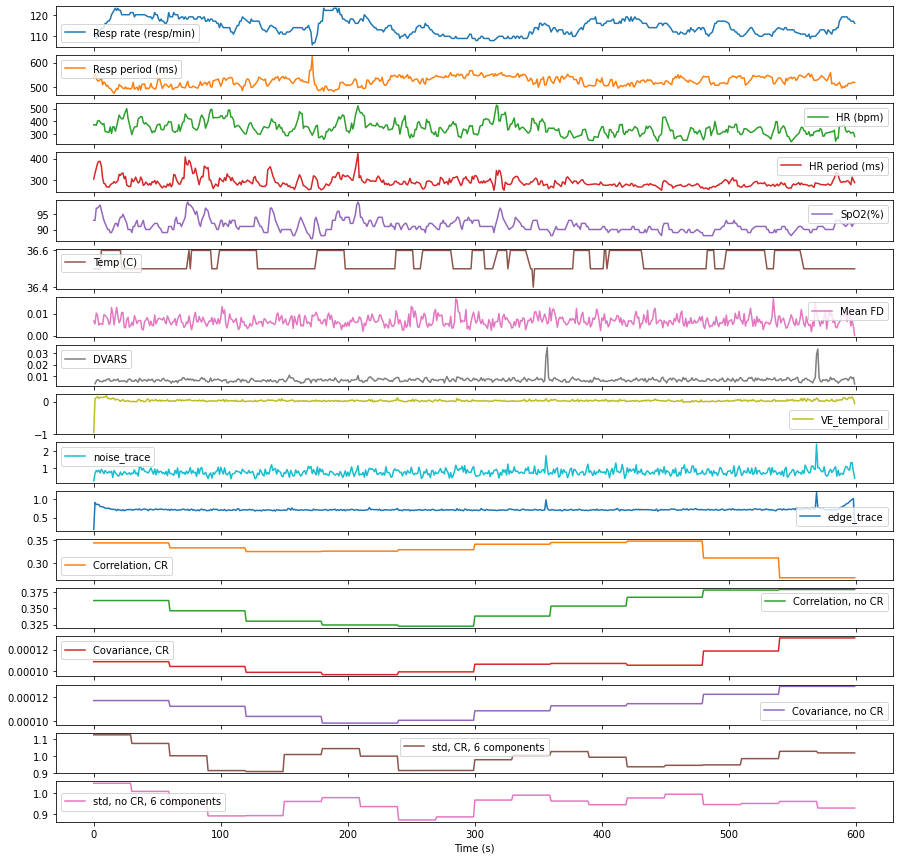

In [143]:
df_all_2min_001.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD', 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR', 'std, CR, 6 components',
                   'std, no CR, 6 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

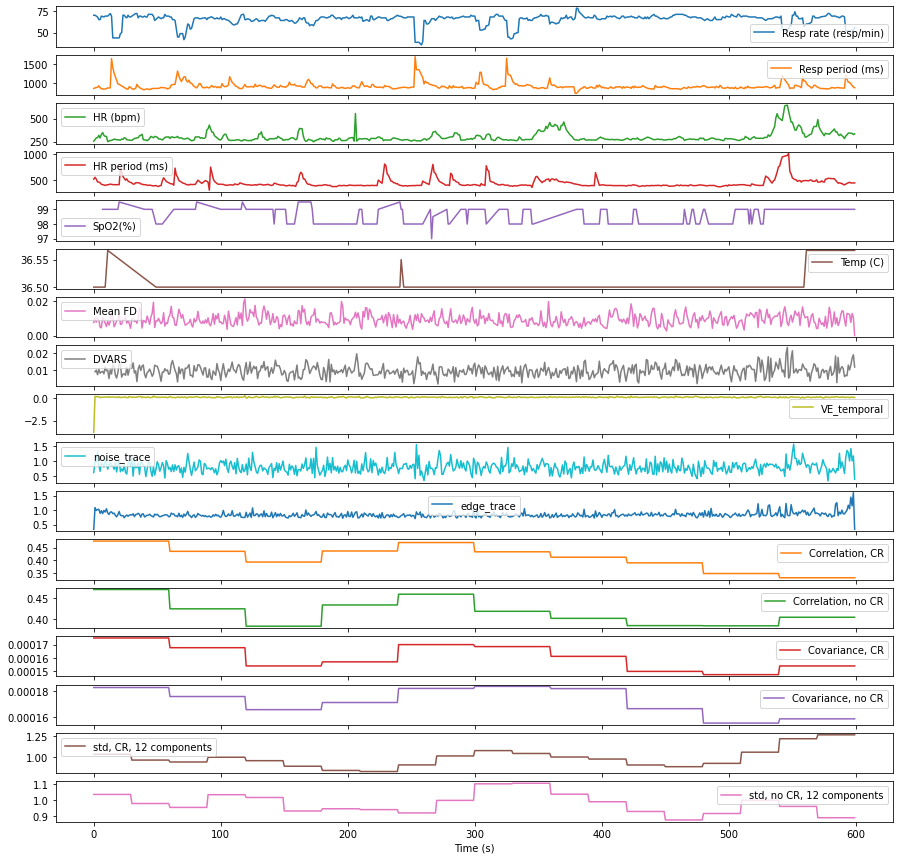

In [145]:
df_all_2min_002.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD', 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR',
                   'std, CR, 12 components','std, no CR, 12 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

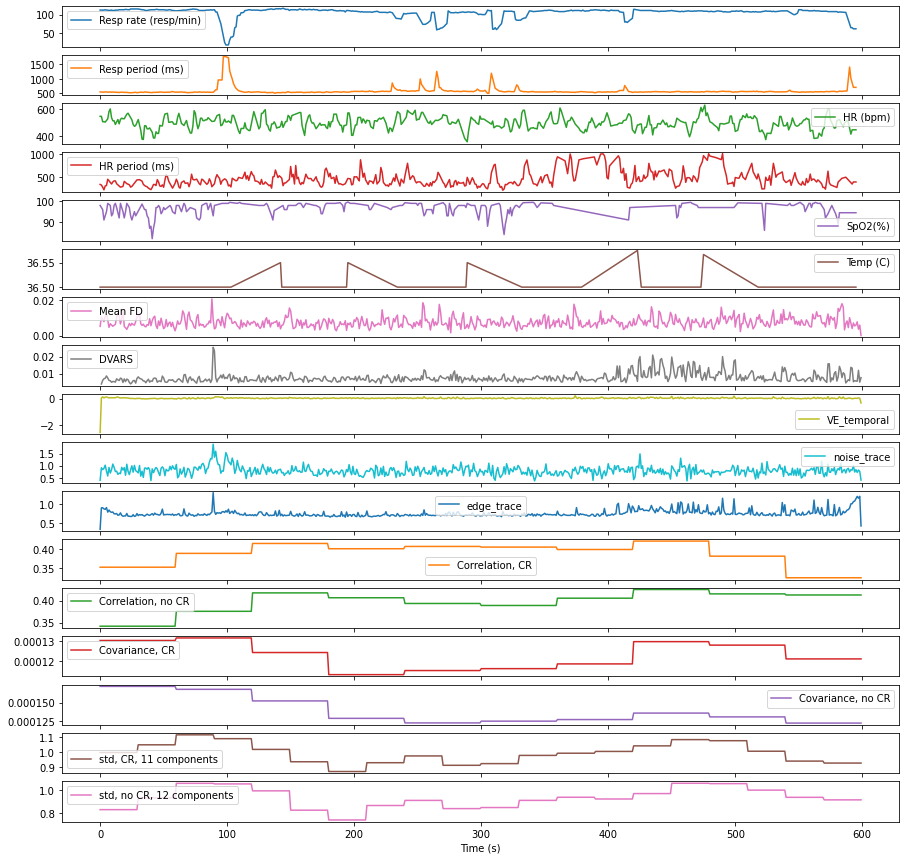

In [146]:
df_all_2min_003.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD' , 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR',
                   'std, CR, 11 components','std, no CR, 12 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

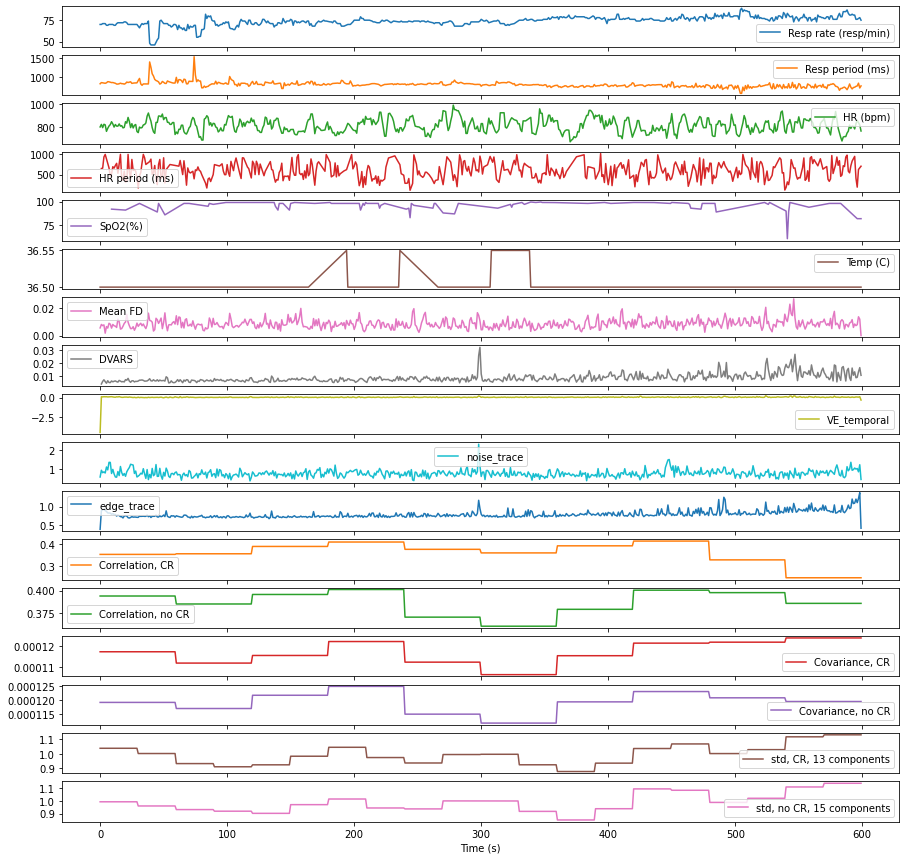

In [147]:
df_all_2min_004.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD', 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR',
                   'std, CR, 13 components','std, no CR, 15 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

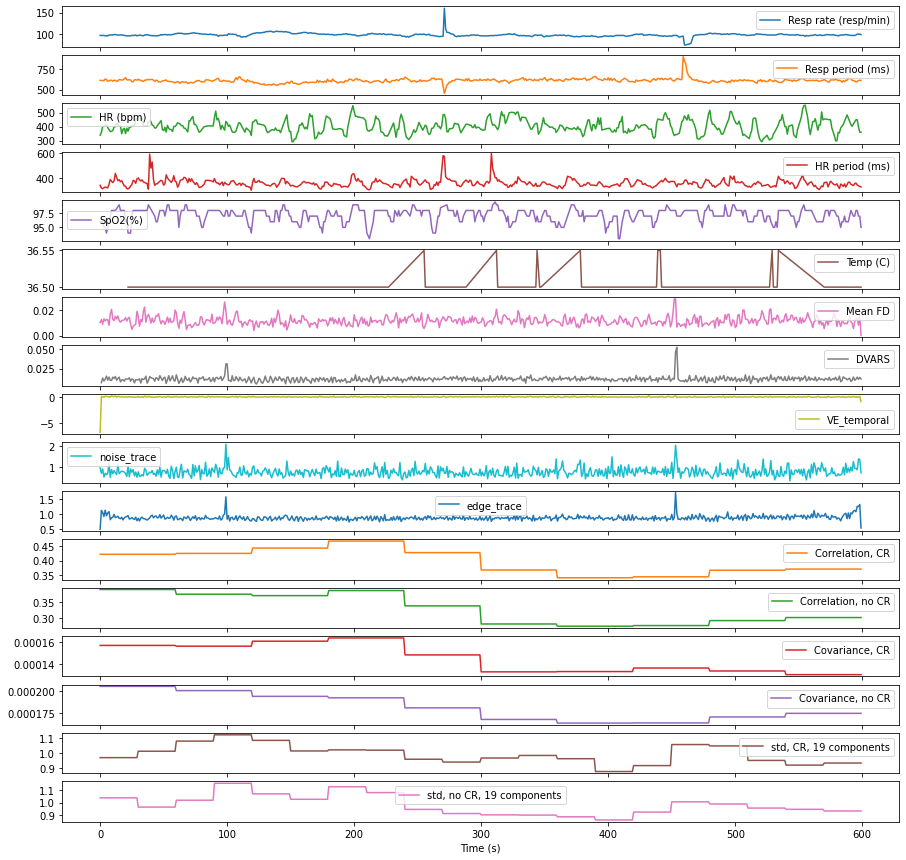

In [148]:
df_all_2min_005.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD', 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR',
                   'std, CR, 19 components','std, no CR, 19 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

array([<AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>, <AxesSubplot:xlabel='Time (s)'>,
       <AxesSubplot:xlabel='Time (s)'>], dtype=object)

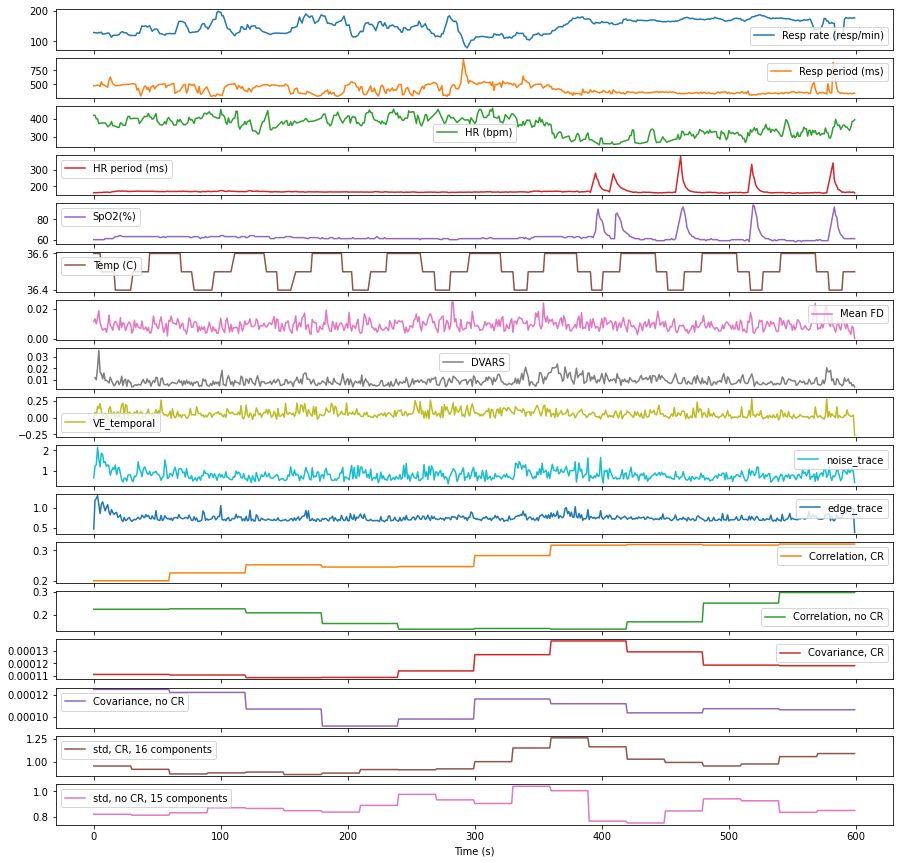

In [61]:
df_all_2min_006.plot(y=['Resp rate (resp/min)', 'Resp period (ms)', 'HR (bpm)', 'HR period (ms)', 'SpO2(%)', 'Temp (C)',
                   'Mean FD', 'DVARS', 'VE_temporal', 'noise_trace', 'edge_trace','Correlation, CR',
                   'Correlation, no CR', 'Covariance, CR','Covariance, no CR','std, CR, 16 components',
                   'std, no CR, 15 components'], 
                xlabel = 'Time (s)', figsize = (15,15), subplots = True)

## Plot select data

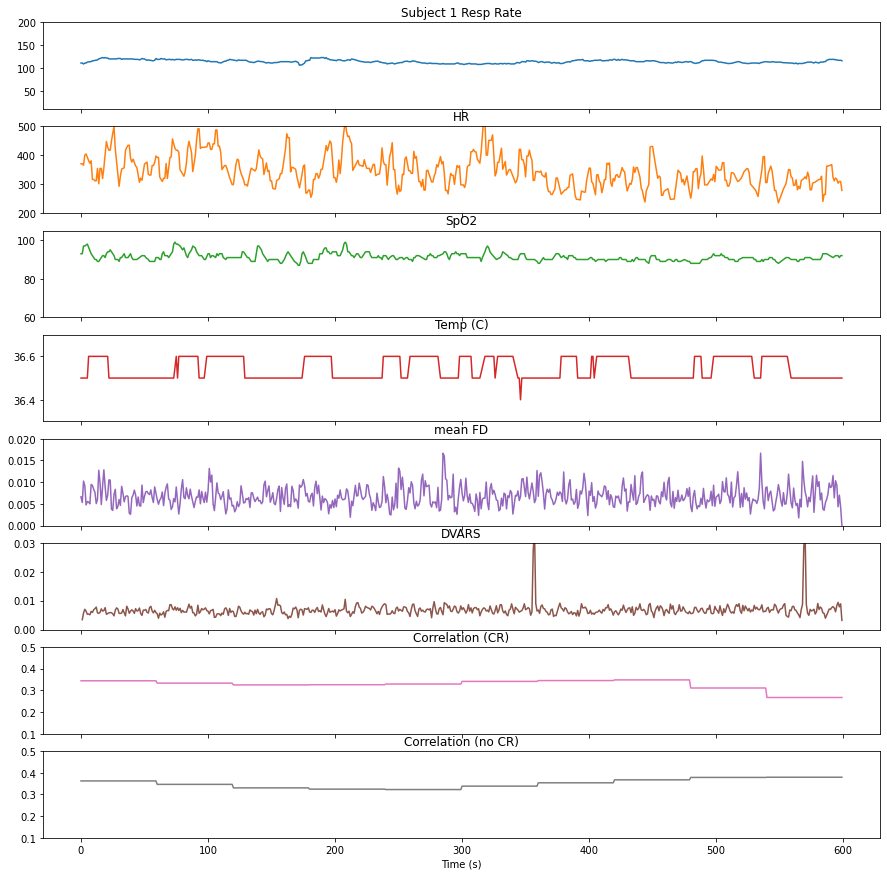

In [75]:
mysubplots = df_all_2min_001.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 1 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([10,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,105])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.5])
mysubplots[7].set_ylim([0.1, 0.5])
plt.show()

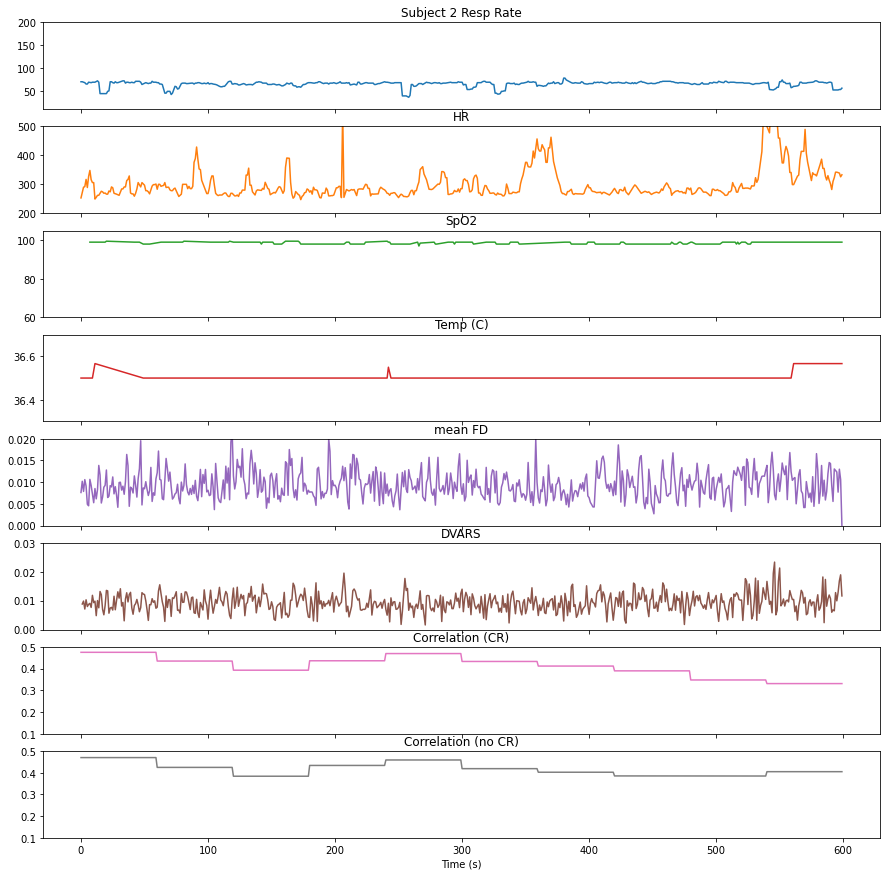

In [76]:
mysubplots = df_all_2min_002.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 2 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([10,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,105])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.5])
mysubplots[7].set_ylim([0.1, 0.5])
plt.show()

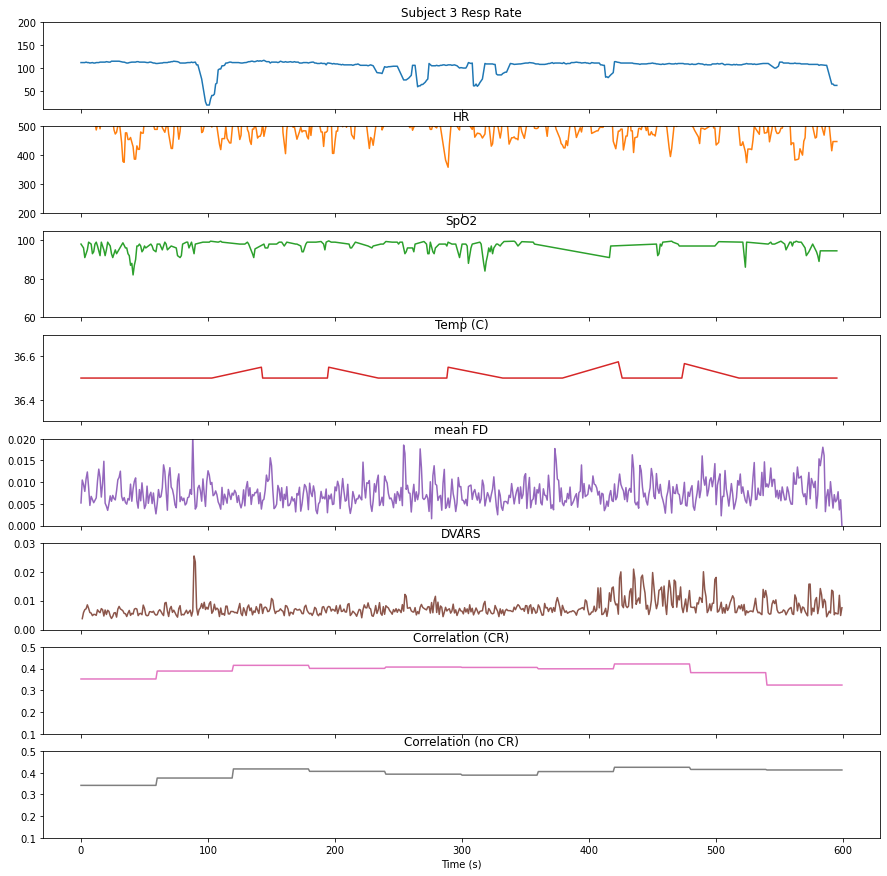

In [77]:
mysubplots = df_all_2min_003.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 3 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([10,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,105])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.5])
mysubplots[7].set_ylim([0.1, 0.5])
plt.show()

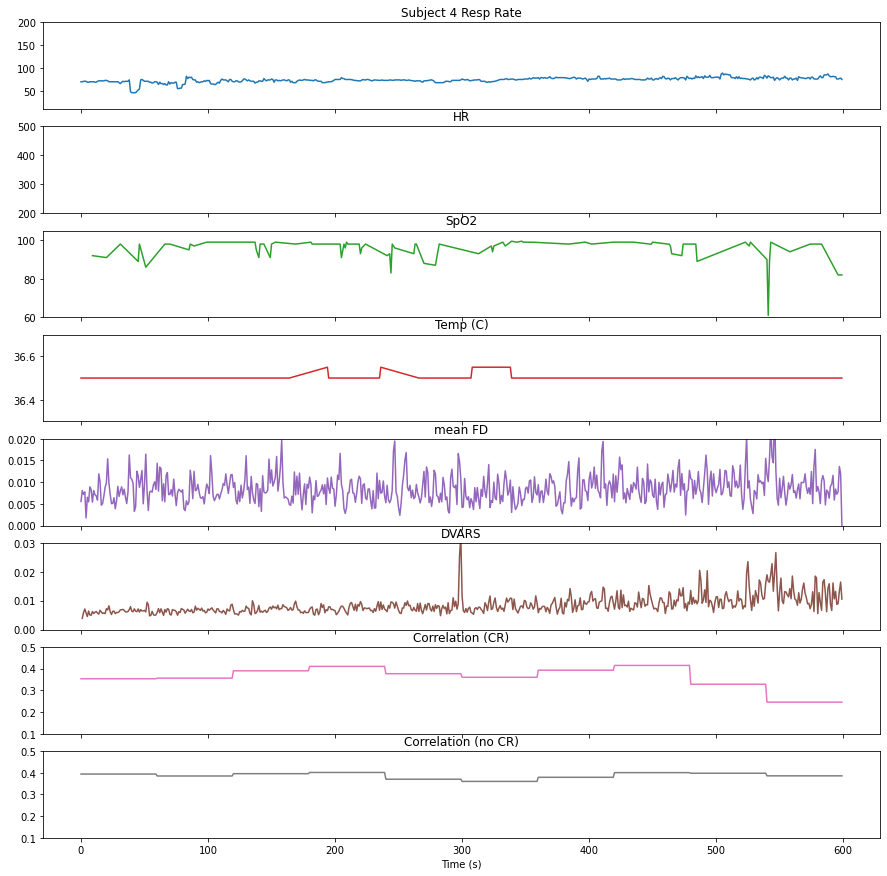

In [78]:
mysubplots = df_all_2min_004.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 4 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([10,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,105])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.5])
mysubplots[7].set_ylim([0.1, 0.5])
plt.show()

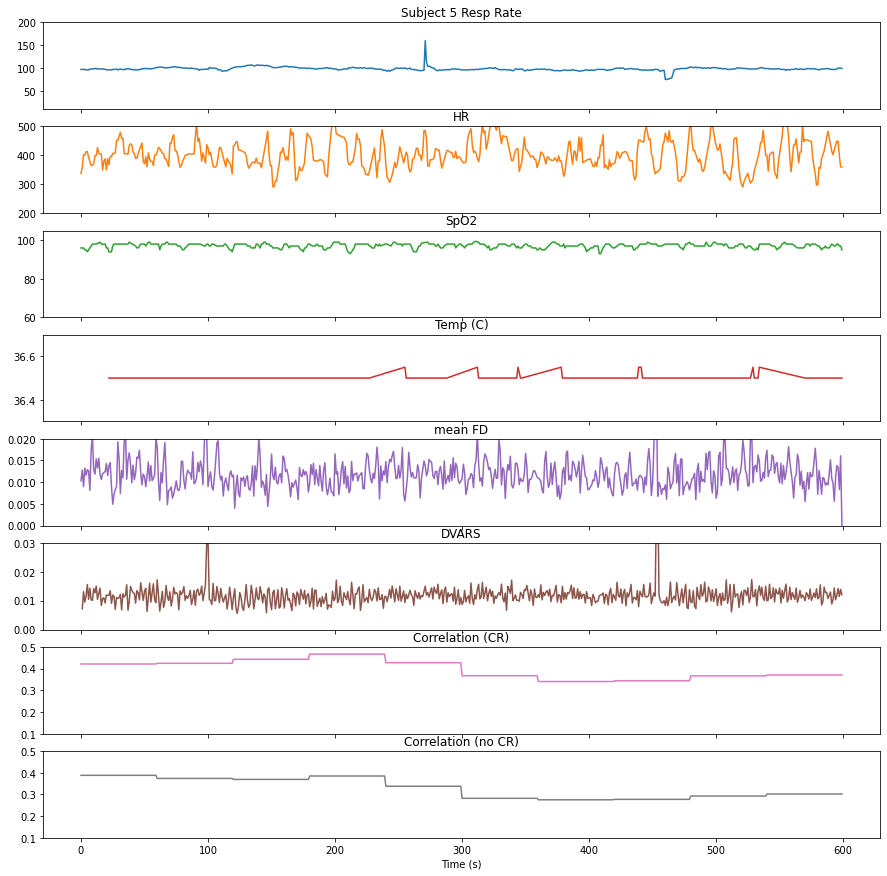

In [79]:
mysubplots = df_all_2min_005.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 5 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([10,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,105])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.5])
mysubplots[7].set_ylim([0.1, 0.5])
plt.show()

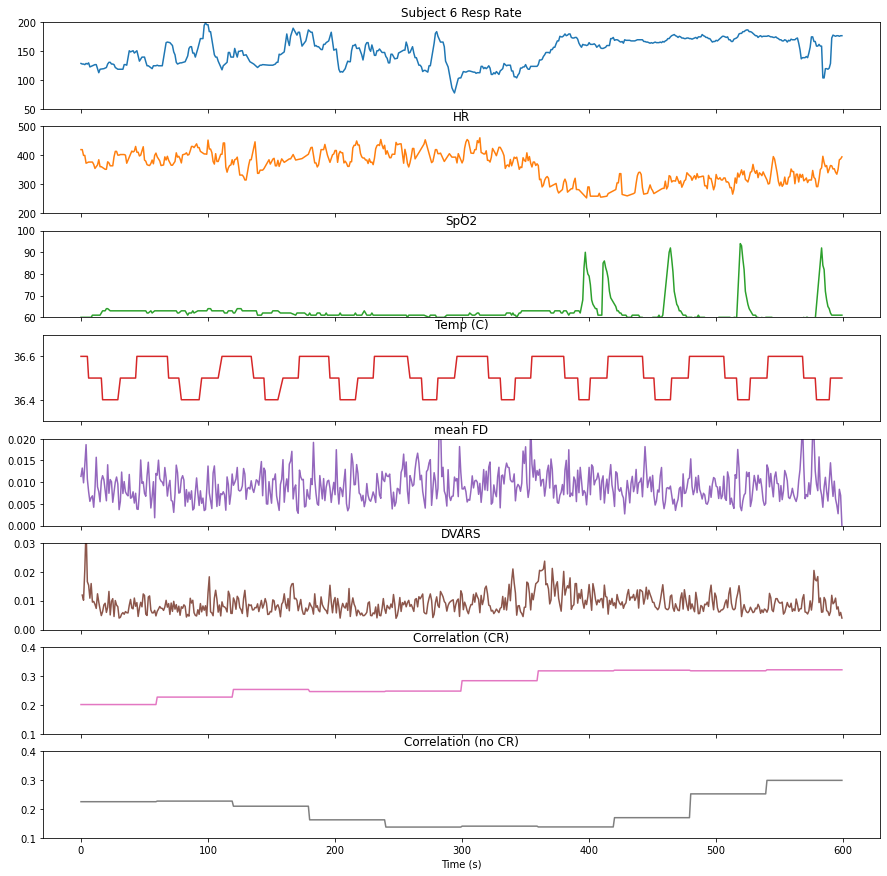

In [80]:
mysubplots = df_all_2min_006.plot(y=['Resp rate (resp/min)', 'HR (bpm)', 'SpO2(%)', 'Temp (C)', 'Mean FD', 'DVARS',
                                     'Correlation, CR','Correlation, no CR'], xlabel = 'Time (s)',
                     title = ['Subject 6 Resp Rate', 'HR', 'SpO2', 'Temp (C)', 'mean FD', 'DVARS', 'Correlation (CR)', 
                              'Correlation (no CR)'],
                     figsize = (15,15), subplots = True, legend = False)
mysubplots[0].set_ylim([50,200])
mysubplots[1].set_ylim([200,500])
mysubplots[2].set_ylim([60,100])
mysubplots[3].set_ylim([36.3,36.7])
mysubplots[4].set_ylim([0,0.02])
mysubplots[5].set_ylim([0,0.03])
mysubplots[6].set_ylim([0.1, 0.4])
mysubplots[7].set_ylim([0.1, 0.4])
plt.show()